In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy import wcs
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import sep
from photutils import CircularAperture
from IPython.display import display
from MUSE_Models import MUSE_3D_OIII, MUSE_3D_residual, PNextractor, data_cube_y_x, Gaussian_1D_res

%config InlineBackend.figure_format = 'retina'

In [19]:
#lnl_cube = fits.open("FCC255_data/FCC255_lnl_cube-005.fits")
Gandalf_fit = fits.open("FCC255_data/FCC255_GandALF_fit-003.fits")
Gandalf_fit_emission = fits.open("FCC255_data/FCC255_GandALF_fit_emission-002.fits")
#ppxf_fit = fits.open("FCC255_data/FCC255_pPXF_fit-004.fits")

#Gandalf_stellar = Gandalf_fit[0].data - Gandalf_fit_emission[0].data
#emission_cube = lnl_cube[0].data - Gandalf_stellar
hdu = fits.PrimaryHDU(Gandalf_stellar)
hdu.writeto("FCC255_data/FCC255_Gandalf_stellar_cube.fits")

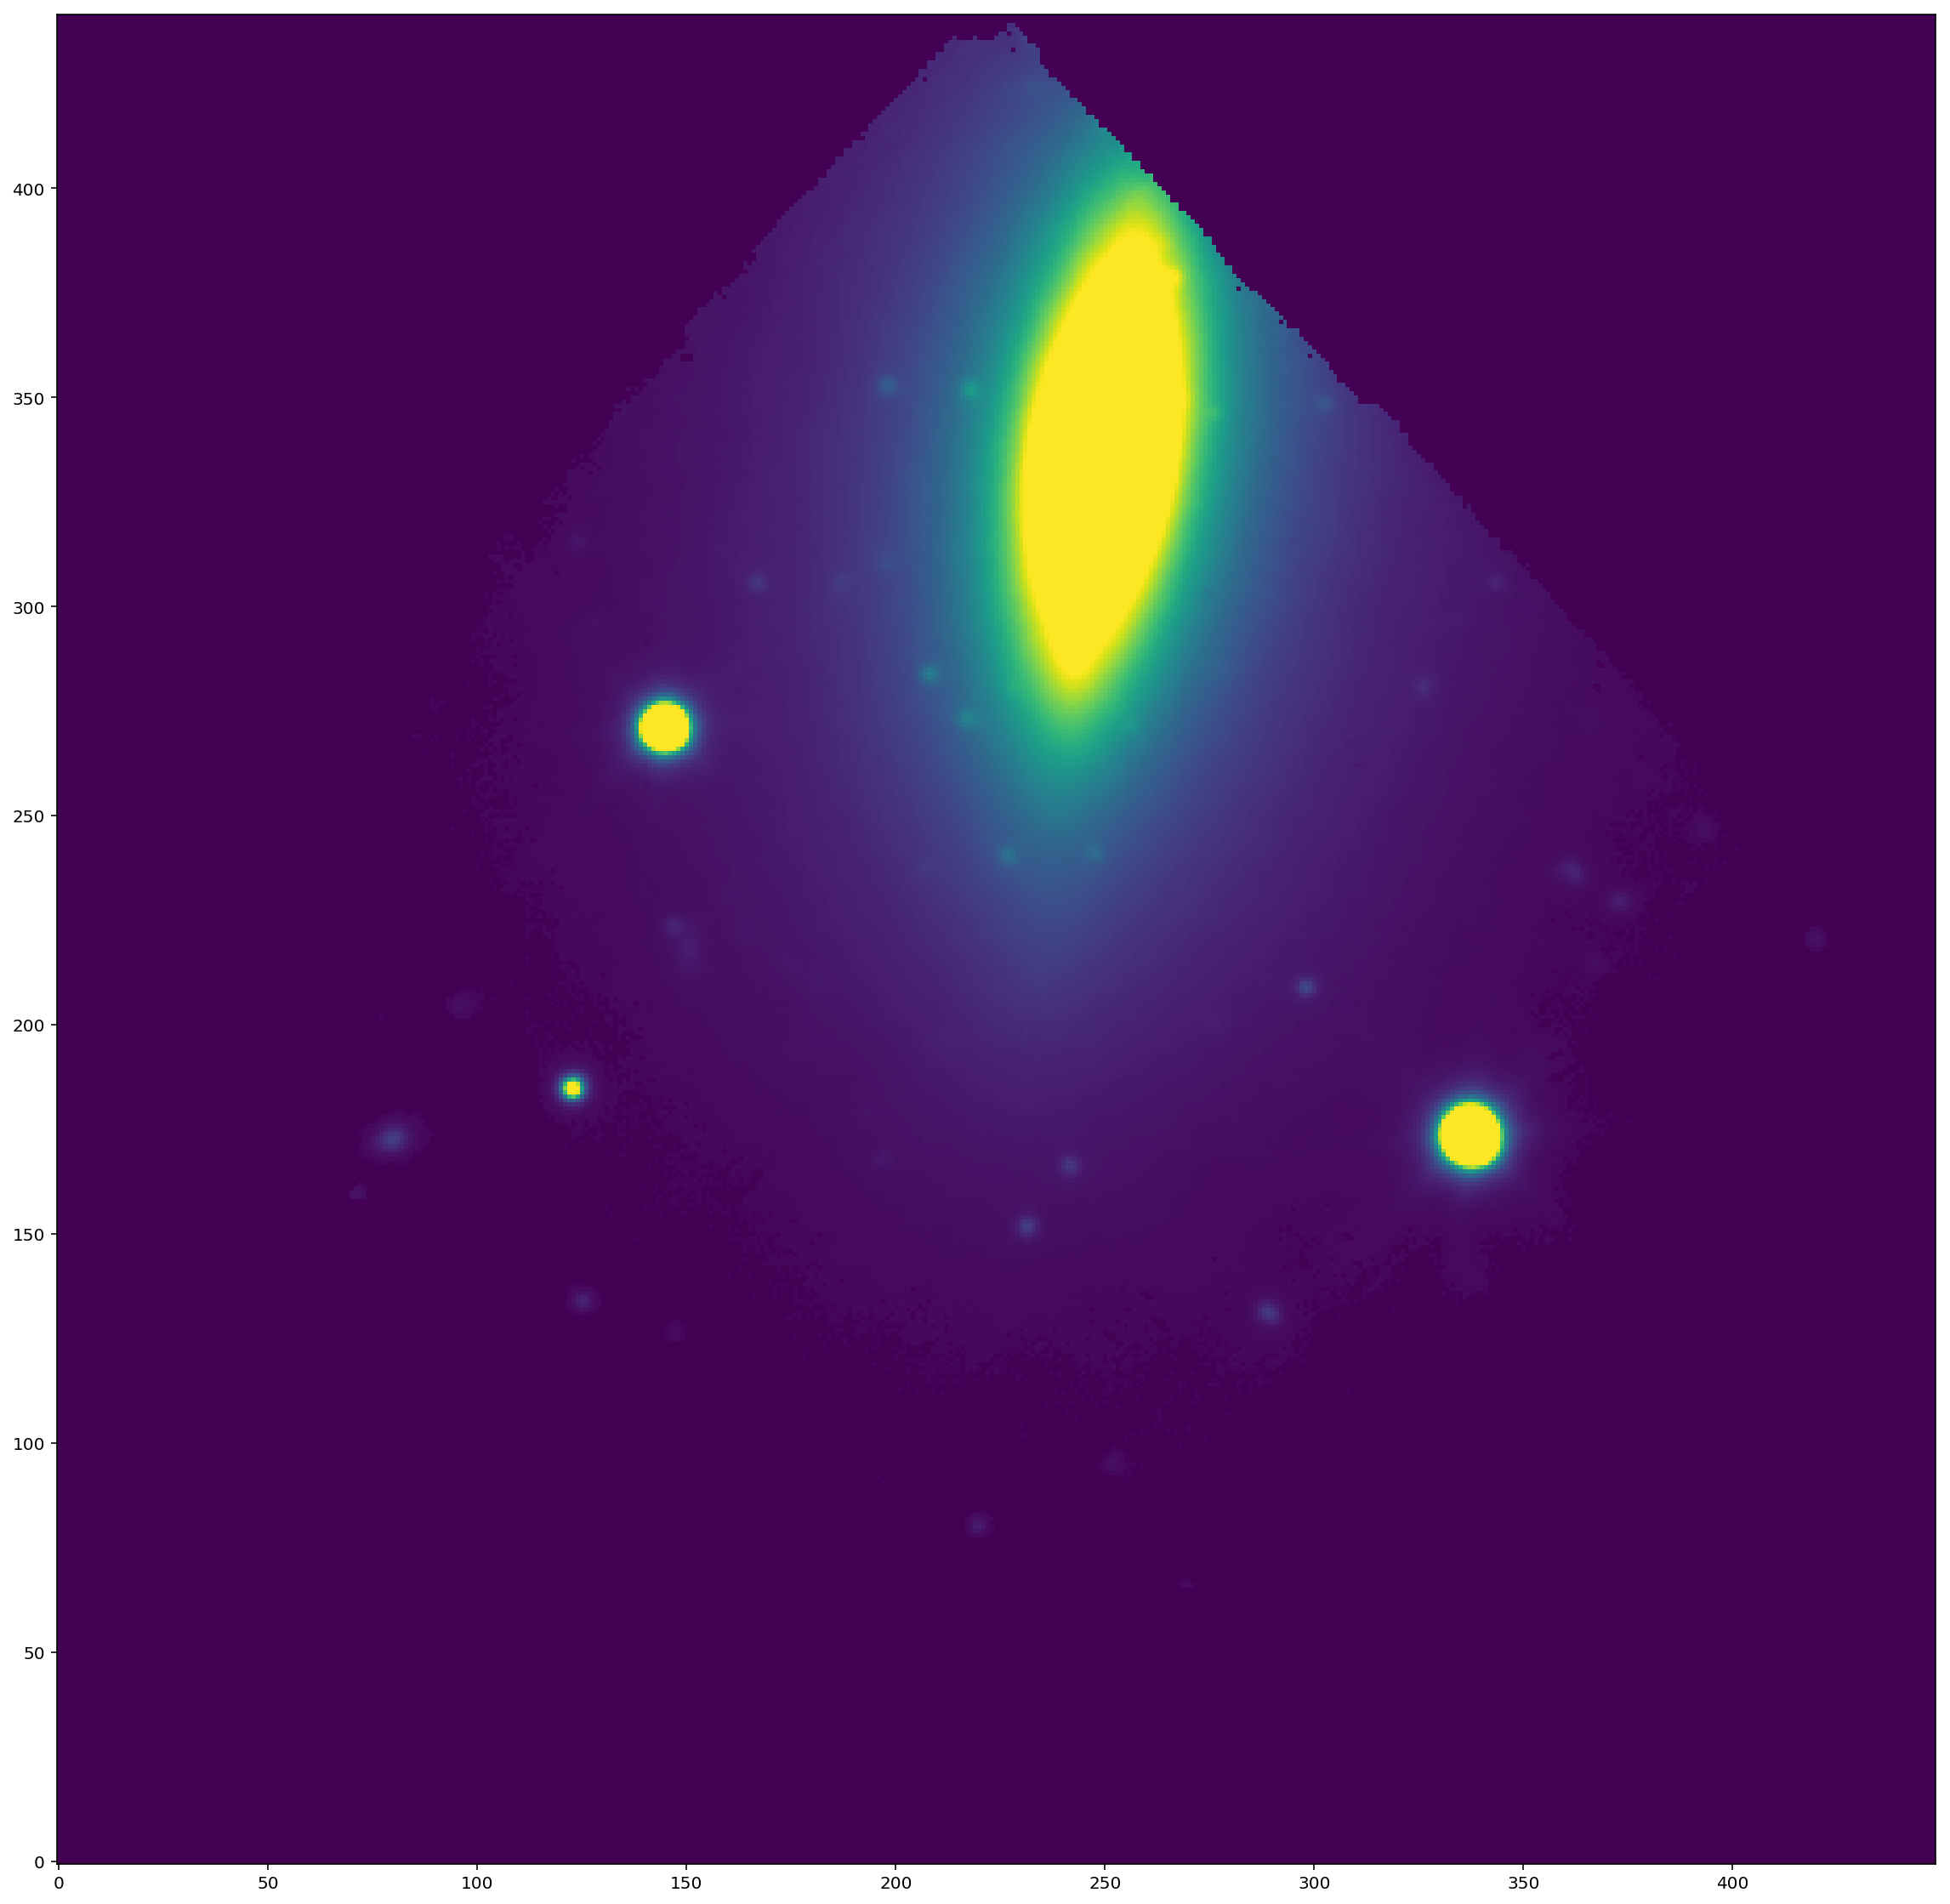

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(np.sum(Gandalf_stellar.reshape(y_data, x_data, len(full_wavelength)),2), origin="lower", vmin=1e3, vmax=3e5)
plt.savefig("Plots/FCC255/stellar_plot.png")

In [3]:
# Open Fits file and assign to raw_data
hdulist = fits.open("FCC255_data/FCC255_emission_cube.fits")
raw_data = hdulist[0].data
hdr = hdulist[0].header

full_wavelength = np.load("exported_data/FCC255/wavelength.npy")
# wavelength[382] = 4940.58678
# wavelength[542] = 5090.374537
wavelength = full_wavelength#[382:543]

y_data, x_data, n_data = data_cube_y_x(len(raw_data))

coordinates = [(n,m) for n in range(x_data) for m in range(y_data)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

oo = np.loadtxt('FCC255_data/FCC255_xy_ima_yngoodspaxels.txt', skiprows=1)
fit_these = oo[:,3]

raw_data_list = raw_data#[:,382:543]

raw_data_list_fitted = np.squeeze(np.where(fit_these == 1))

raw_data_list_for_fit = raw_data_list[raw_data_list_fitted]

In [4]:
params = Parameters()
params.add("Amp",value=70., min=0.001)
params.add("mean", value=5030., min=5000., max=5080.)
params.add("FWHM", value=2.81, vary=False) # LSF
params.add("Gauss_bkg", value=0.001, min=-500., max=500.)
params.add("Gauss_grad", value=0.001)

list_of_std = np.array([np.abs(np.std(spec)) for spec in raw_data_list])
input_errors = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0,len(list_of_std))]

list_of_rN = np.zeros(len(raw_data_list))
list_of_residuals = np.zeros((len(raw_data_list),len(wavelength)))
list_of_residuals_from_fitter = np.zeros((len(raw_data_list),len(wavelength)))
best_fit_A = np.zeros((len(raw_data_list),2))
best_fit_mean = np.zeros((len(raw_data_list),2))

In [ ]:
for spec_n in raw_data_list_fitted:
    results = minimize(Gaussian_1D_res, params, args=(wavelength, raw_data_list[spec_n], input_errors[spec_n], spec_n), nan_policy="propagate")
    best_fit_A[spec_n] = [results.params["Amp"], results.params["Amp"].stderr]
    best_fit_mean[spec_n] = [results.params["mean"], results.params["mean"].stderr]
    list_of_residuals_from_fitter[spec_n] = results.residual

In [8]:
gauss_A = [A[0] for A in best_fit_A]
A_err = [A[1] for A in best_fit_A]

A_rN = np.array([A / rN for A,rN in zip(gauss_A, list_of_rN)])
A_rN_shape = A_rN.reshape(y_data,x_data)

Gauss_F = np.array(gauss_A) * np.sqrt(2*np.pi) * 1.19
Gauss_F_shape = Gauss_F.reshape(y_data, x_data)

/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [10]:
np.save("exported_data/FCC255/A_rN_cen", A_rN)
np.save("exported_data/FCC255/gauss_A_cen", gauss_A)
np.save("exported_data/FCC255/gauss_A_err_cen", A_err)
np.save("exported_data/FCC255/gauss_F_cen", Gauss_F)
np.save("exported_data/FCC255/list_of_resids_min", list_of_residuals)
np.save("exported_data/FCC255/list_of_resids_min_obj", list_of_residuals_from_fitter)
np.save("exported_data/FCC255/rN", list_of_rN)

In [3]:
A_rN = np.load("exported_data/FCC255/A_rN_cen.npy")
gauss_A = np.load("exported_data/FCC255/gauss_A_cen.npy")
Gauss_F = np.load("exported_data/FCC255/gauss_F_cen.npy")

gauss_A_shape = gauss_A.reshape(y_data, x_data)
A_rN_shape = A_rN.reshape(y_data,x_data)
Gauss_F_shape = Gauss_F.reshape(y_data, x_data)

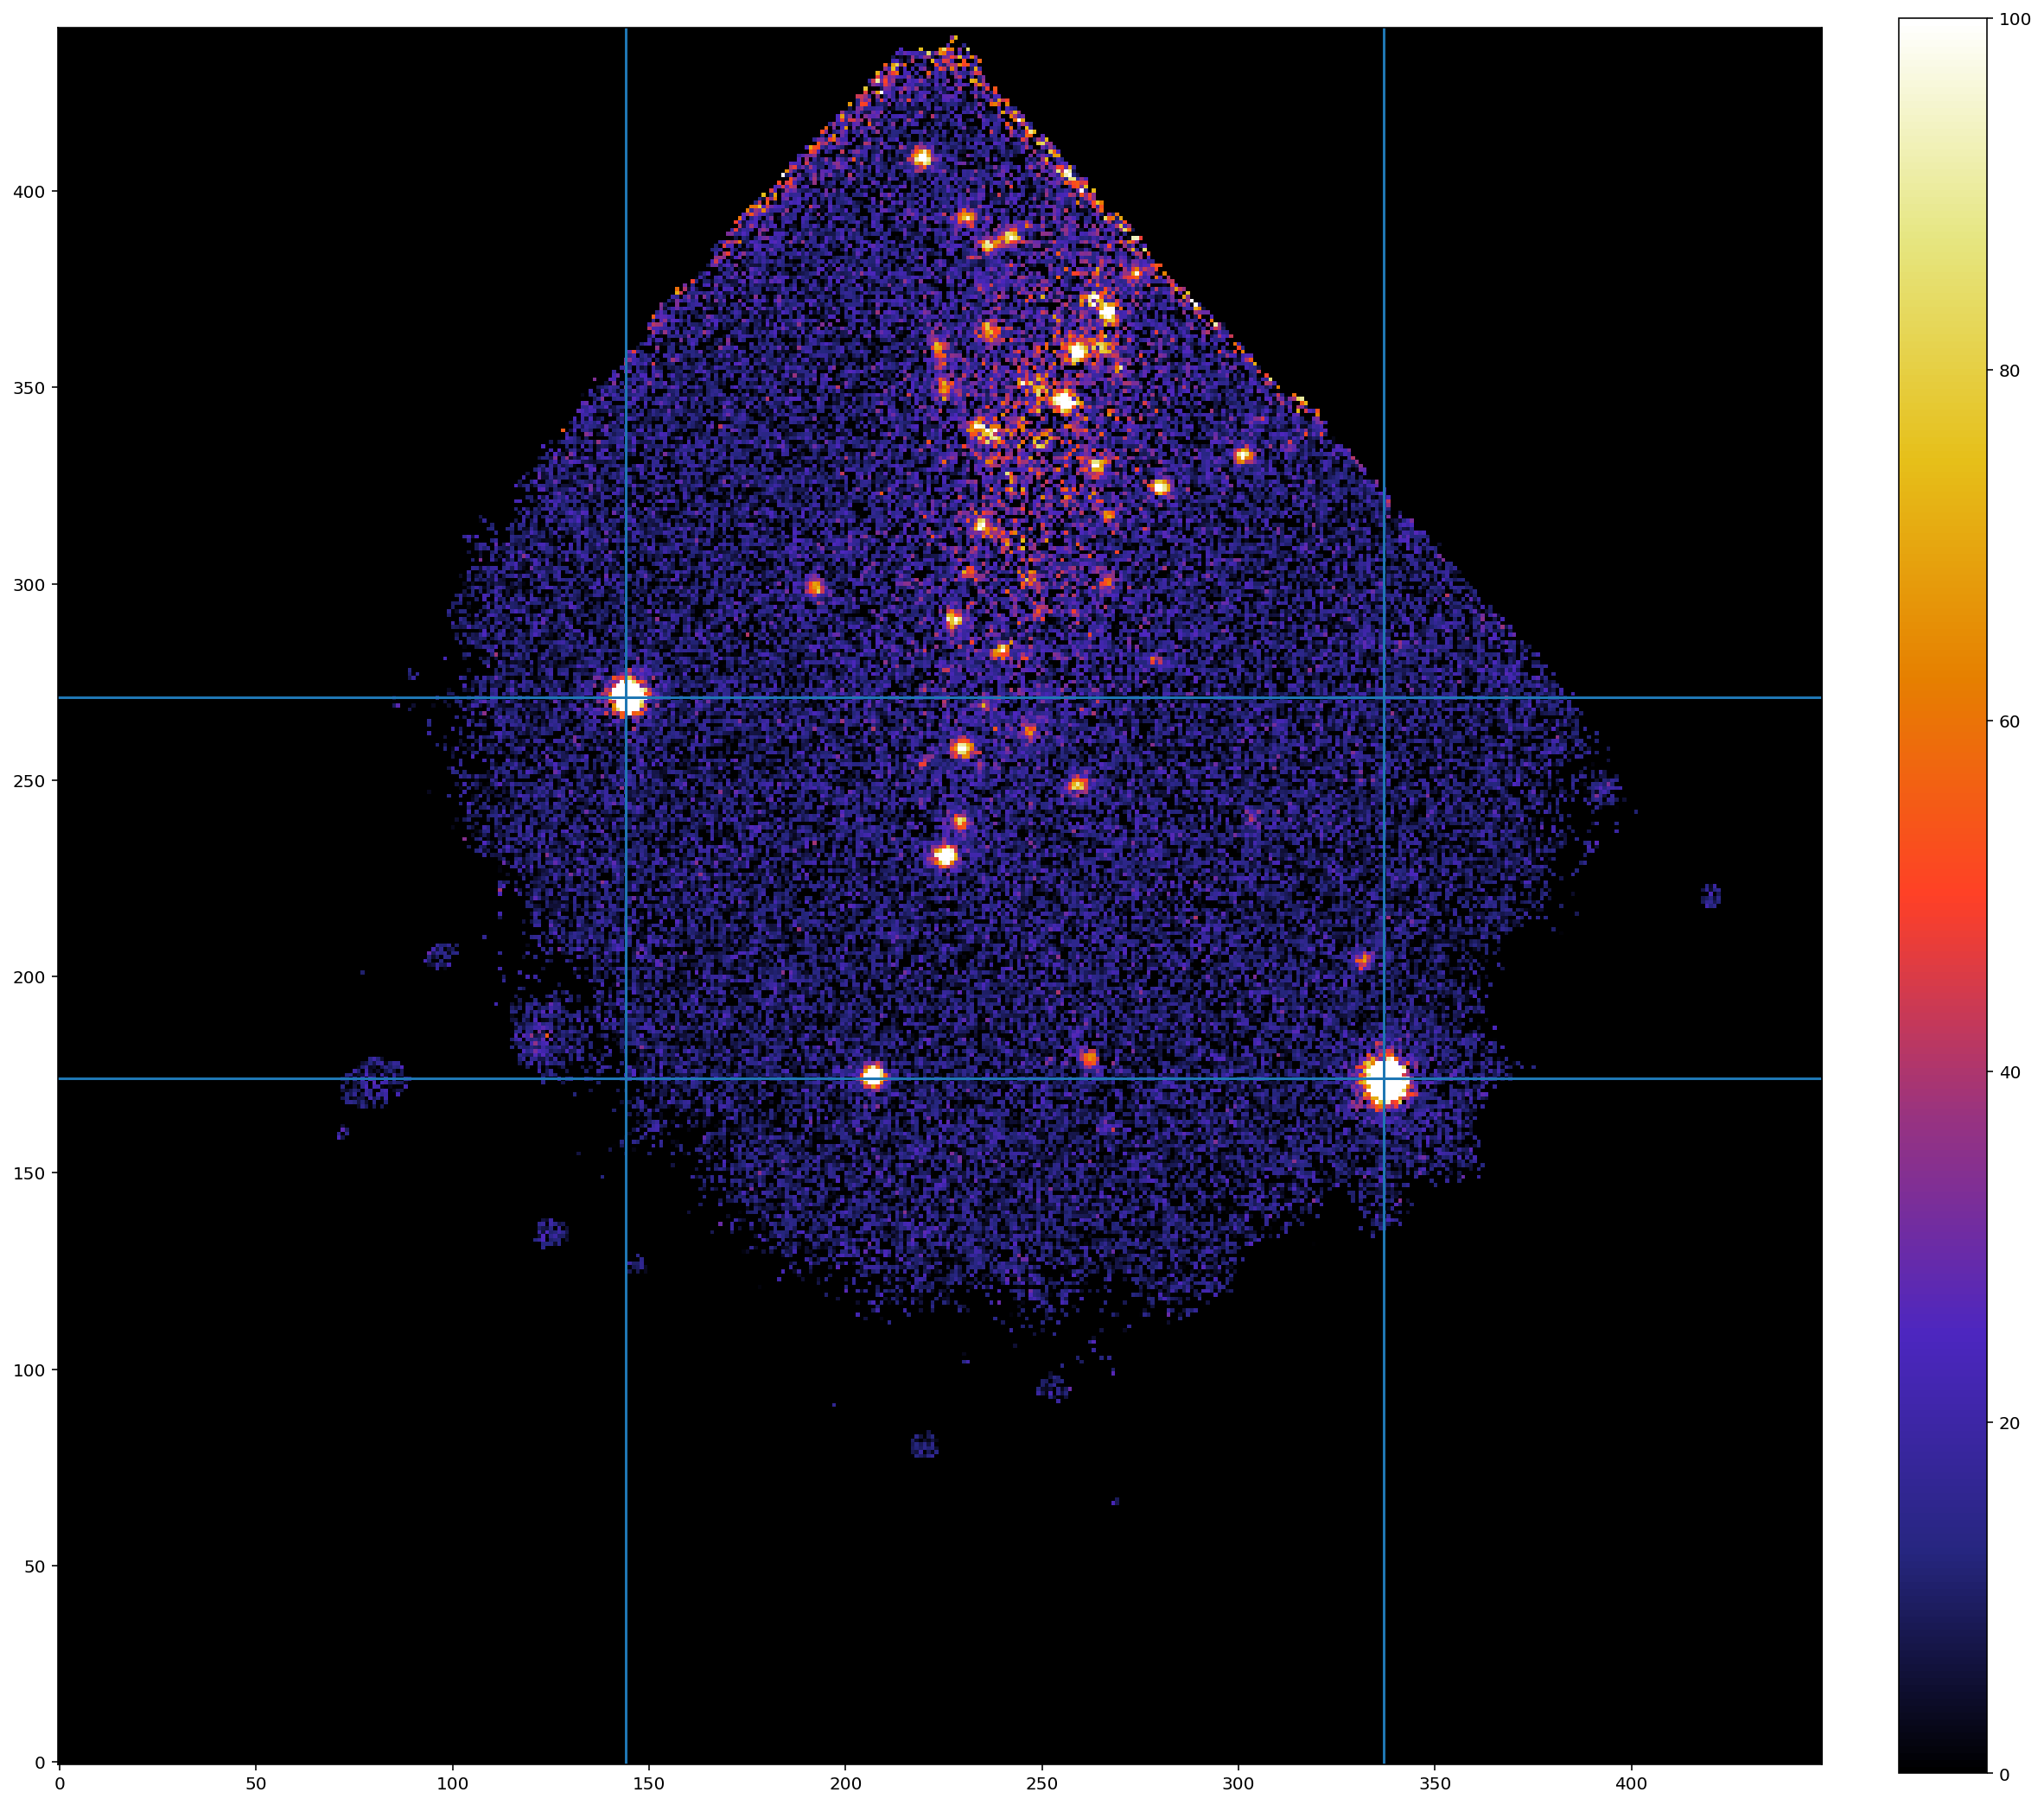

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(Gauss_F_shape, origin="lower", cmap="CMRmap", vmin=0, vmax=100)
plt.colorbar(fraction=0.0455, pad=0.04)
plt.savefig("Plots/FCC255/Fluxmap.png")
n_pix = 20
plt.axhline(174)
plt.axvline(337)
star_0 = PNextractor(337, 174, n_pix, Gauss_F_shape )

plt.axhline(271)
plt.axvline(144)
star_1 = PNextractor(144, 271, n_pix, Gauss_F_shape)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 400
    # variables        = 6
    chi-square         = 1209100.95
    reduced chi-square = 3068.78415
    Akaike info crit   = 3217.56923
    Bayesian info crit = 3241.51802
[[Variables]]
    moff_amp:  2522.96188 +/- 36.8047841 (1.46%) (init = 9000)
    x_0:       9.62917753 +/- 0.01885295 (0.20%) (init = 10)
    y_0:       10.3366186 +/- 0.01885306 (0.18%) (init = 10)
    FWHM:      3.83170976 +/- 0.05360307 (1.40%) (init = 6)
    beta:      3.16206362 +/- 0.33756459 (10.68%) (init = 2)
    bkg:       9.70146667 +/- 4.46472007 (46.02%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(moff_amp, FWHM) = -0.839
    C(FWHM, beta)     =  0.724
    C(beta, bkg)      =  0.670
    C(moff_amp, beta) = -0.621
    C(moff_amp, bkg)  = -0.362
    C(FWHM, bkg)      =  0.259
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 94
    # dat

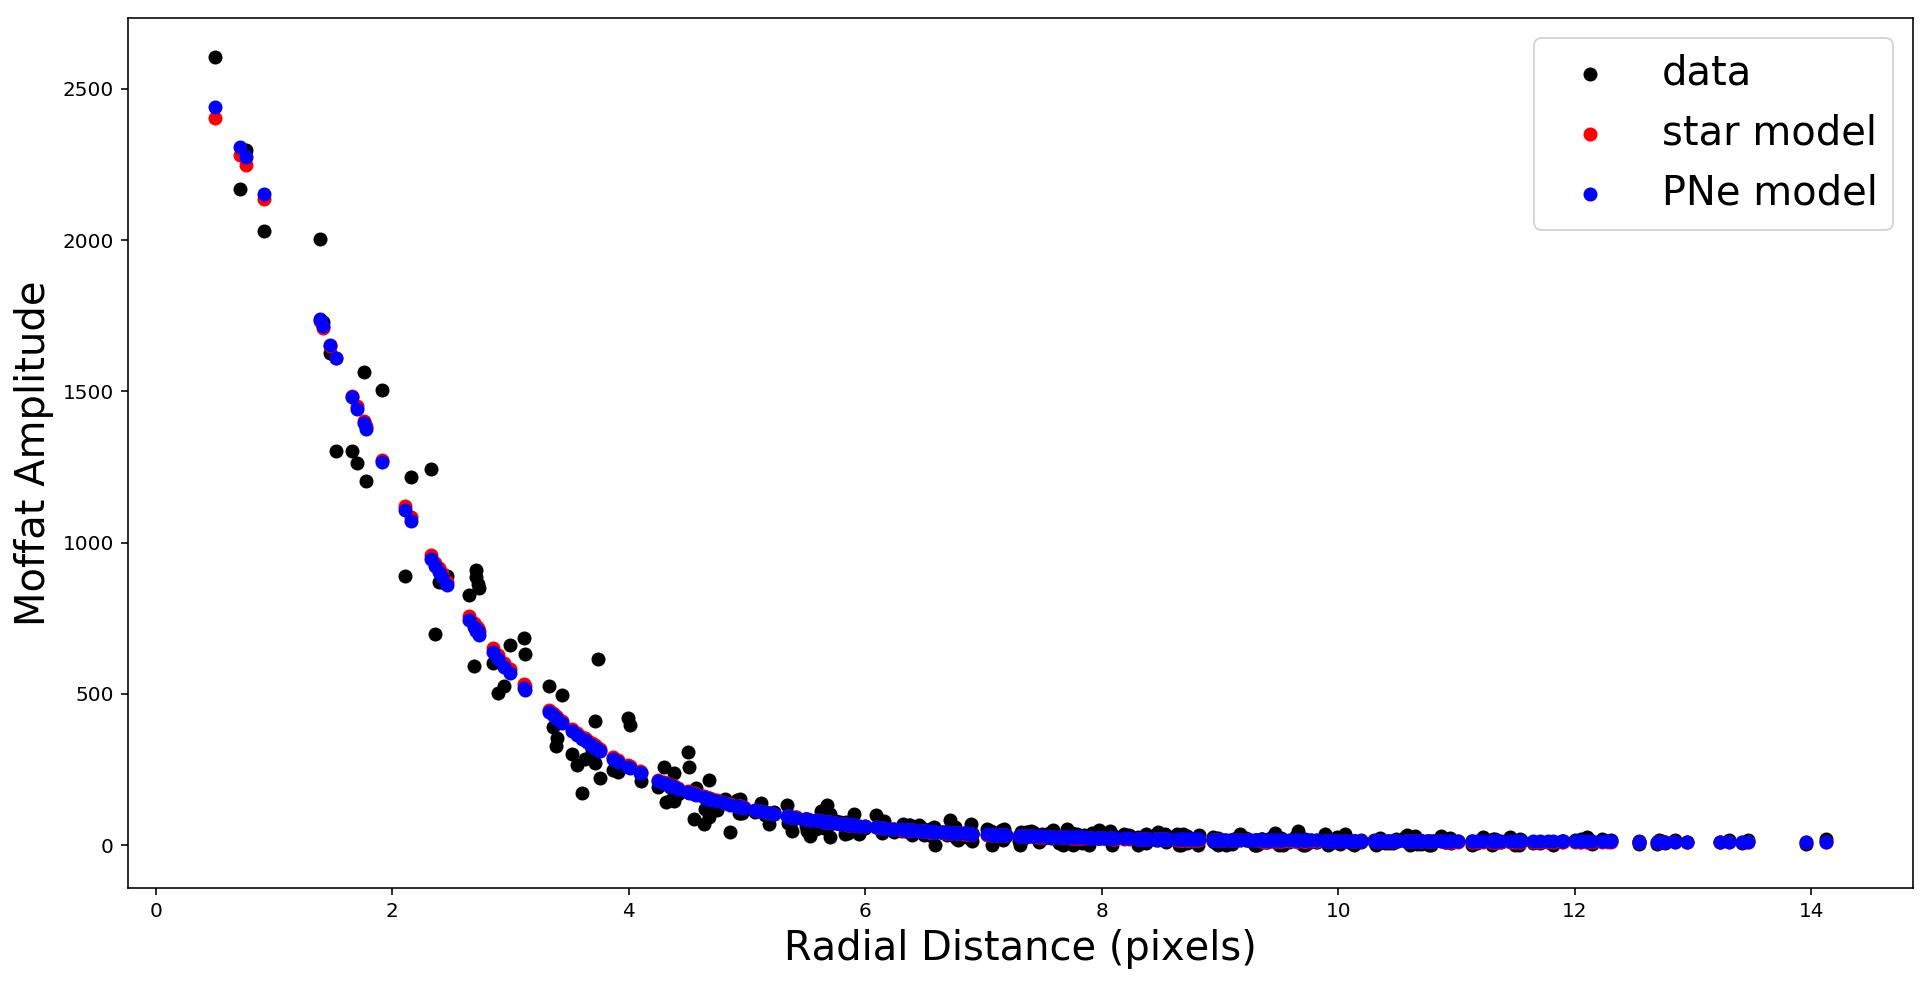

In [14]:
X_AOI, Y_AOI = np.mgrid[:n_pix,:n_pix]
star_ = star_0
coordinates = [(n,m) for n in range(n_pix) for m in range(n_pix)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

#list_of_residuals = np.zeros(len())
list_of_flux = []

def residuals(params, x_2D, y_2D, data):
    moff_amp = params["moff_amp"]
    x_0 = params["x_0"]
    y_0 = params["y_0"]
    FWHM = params["FWHM"]
    beta = params["beta"]
    bkg = params["bkg"]

    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((np.array(x_2D) - x_0)**2 + (np.array(y_2D) - y_0)**2) / gamma**2
    model = moff_amp * (1 + rr_gg)**(-beta) + bkg
    list_of_flux.clear()
    list_of_flux.append(model)
    #list_of_residuals[spec_num] = np.std(data - model)
    
    return data - model #/ np.std(flatten(data))

# Star initial parameters
S_params = Parameters()
S_params.add('moff_amp', value=9000., min=0.0001)
S_params.add('x_0', value=(n_pix/2), min=0001., max=n_pix)
S_params.add('y_0', value=(n_pix/2), min=0001., max=n_pix)
S_params.add('FWHM', value=6., min=0.001, max=30., vary=True)
S_params.add("beta", value=2., min=0.001, vary=True)
S_params.add("bkg", value=0.001, min=0.00001, max=10000, vary=True)

#list_of_std = [np.abs(np.std(spec)) for spec in flat_raw_data]
#input_errors = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0,len(list_of_std))]

S_results = minimize(residuals, S_params, args=(x_fit, y_fit, star_), nan_policy="propagate")
print(report_fit(S_results))
star_model = list_of_flux

# PNe initial Parameters
P_params = Parameters()
P_params.add('moff_amp', value=9000., min=0.0001)
P_params.add('x_0', value=(n_pix/2), min=0001., max=n_pix)
P_params.add('y_0', value=(n_pix/2), min=0001., max=n_pix)
P_params.add('FWHM', value=3.758, min=0.001, max=12., vary=False)
P_params.add("beta", value=3.04, min=0.001, max=12., vary=False)
P_params.add("bkg", value=0.01, min=0.00001, max=10000, vary=True)
#S_results.params["bkg"].value
#FWHM:  4.08291829123 0.106292926432
#Beta:  2.12207462875 0.195897897074


P_results = minimize(residuals, P_params, args=(x_fit, y_fit, star_), nan_policy="propagate")
print(report_fit(P_results))
PNe_model = list_of_flux

PNe_residuals = residuals(P_results.params, x_fit, y_fit, star_)
PNe_model = star_ - PNe_residuals

star_residuals = residuals(S_results.params, x_fit, y_fit, star_)
star_model = star_ - star_residuals

rad= np.sqrt((x_fit - S_results.params["x_0"])**2 + (y_fit - S_results.params["y_0"])**2)
plt.figure(figsize=(16,8))
plt.scatter(rad, star_, color="k", label="data")
plt.scatter(rad, star_model, color="r", label="star model")
plt.scatter(rad, PNe_model, color="blue", label="PNe model")
plt.legend(prop={"size":20})
plt.xlabel("Radial Distance (pixels)", fontsize=20)
plt.ylabel("Moffat Amplitude", fontsize=20)
plt.savefig("Plots/FCC255/radial_comparison.png")

In [21]:
print("Star Total Flux: ", np.sum(star_))
print("Star Model Flux: ", np.sum(star_model))
print("PNe Model Flux:  ", np.sum(PNe_model))
print("Delta flux:      ", np.abs(np.sum(star_model)-np.sum(PNe_model)))

Star Total Flux:  58301.14403692686
Star Model Flux:  58301.14528995437
PNe Model Flux:   58301.14402567736
Delta flux:       0.001264277016161941


31


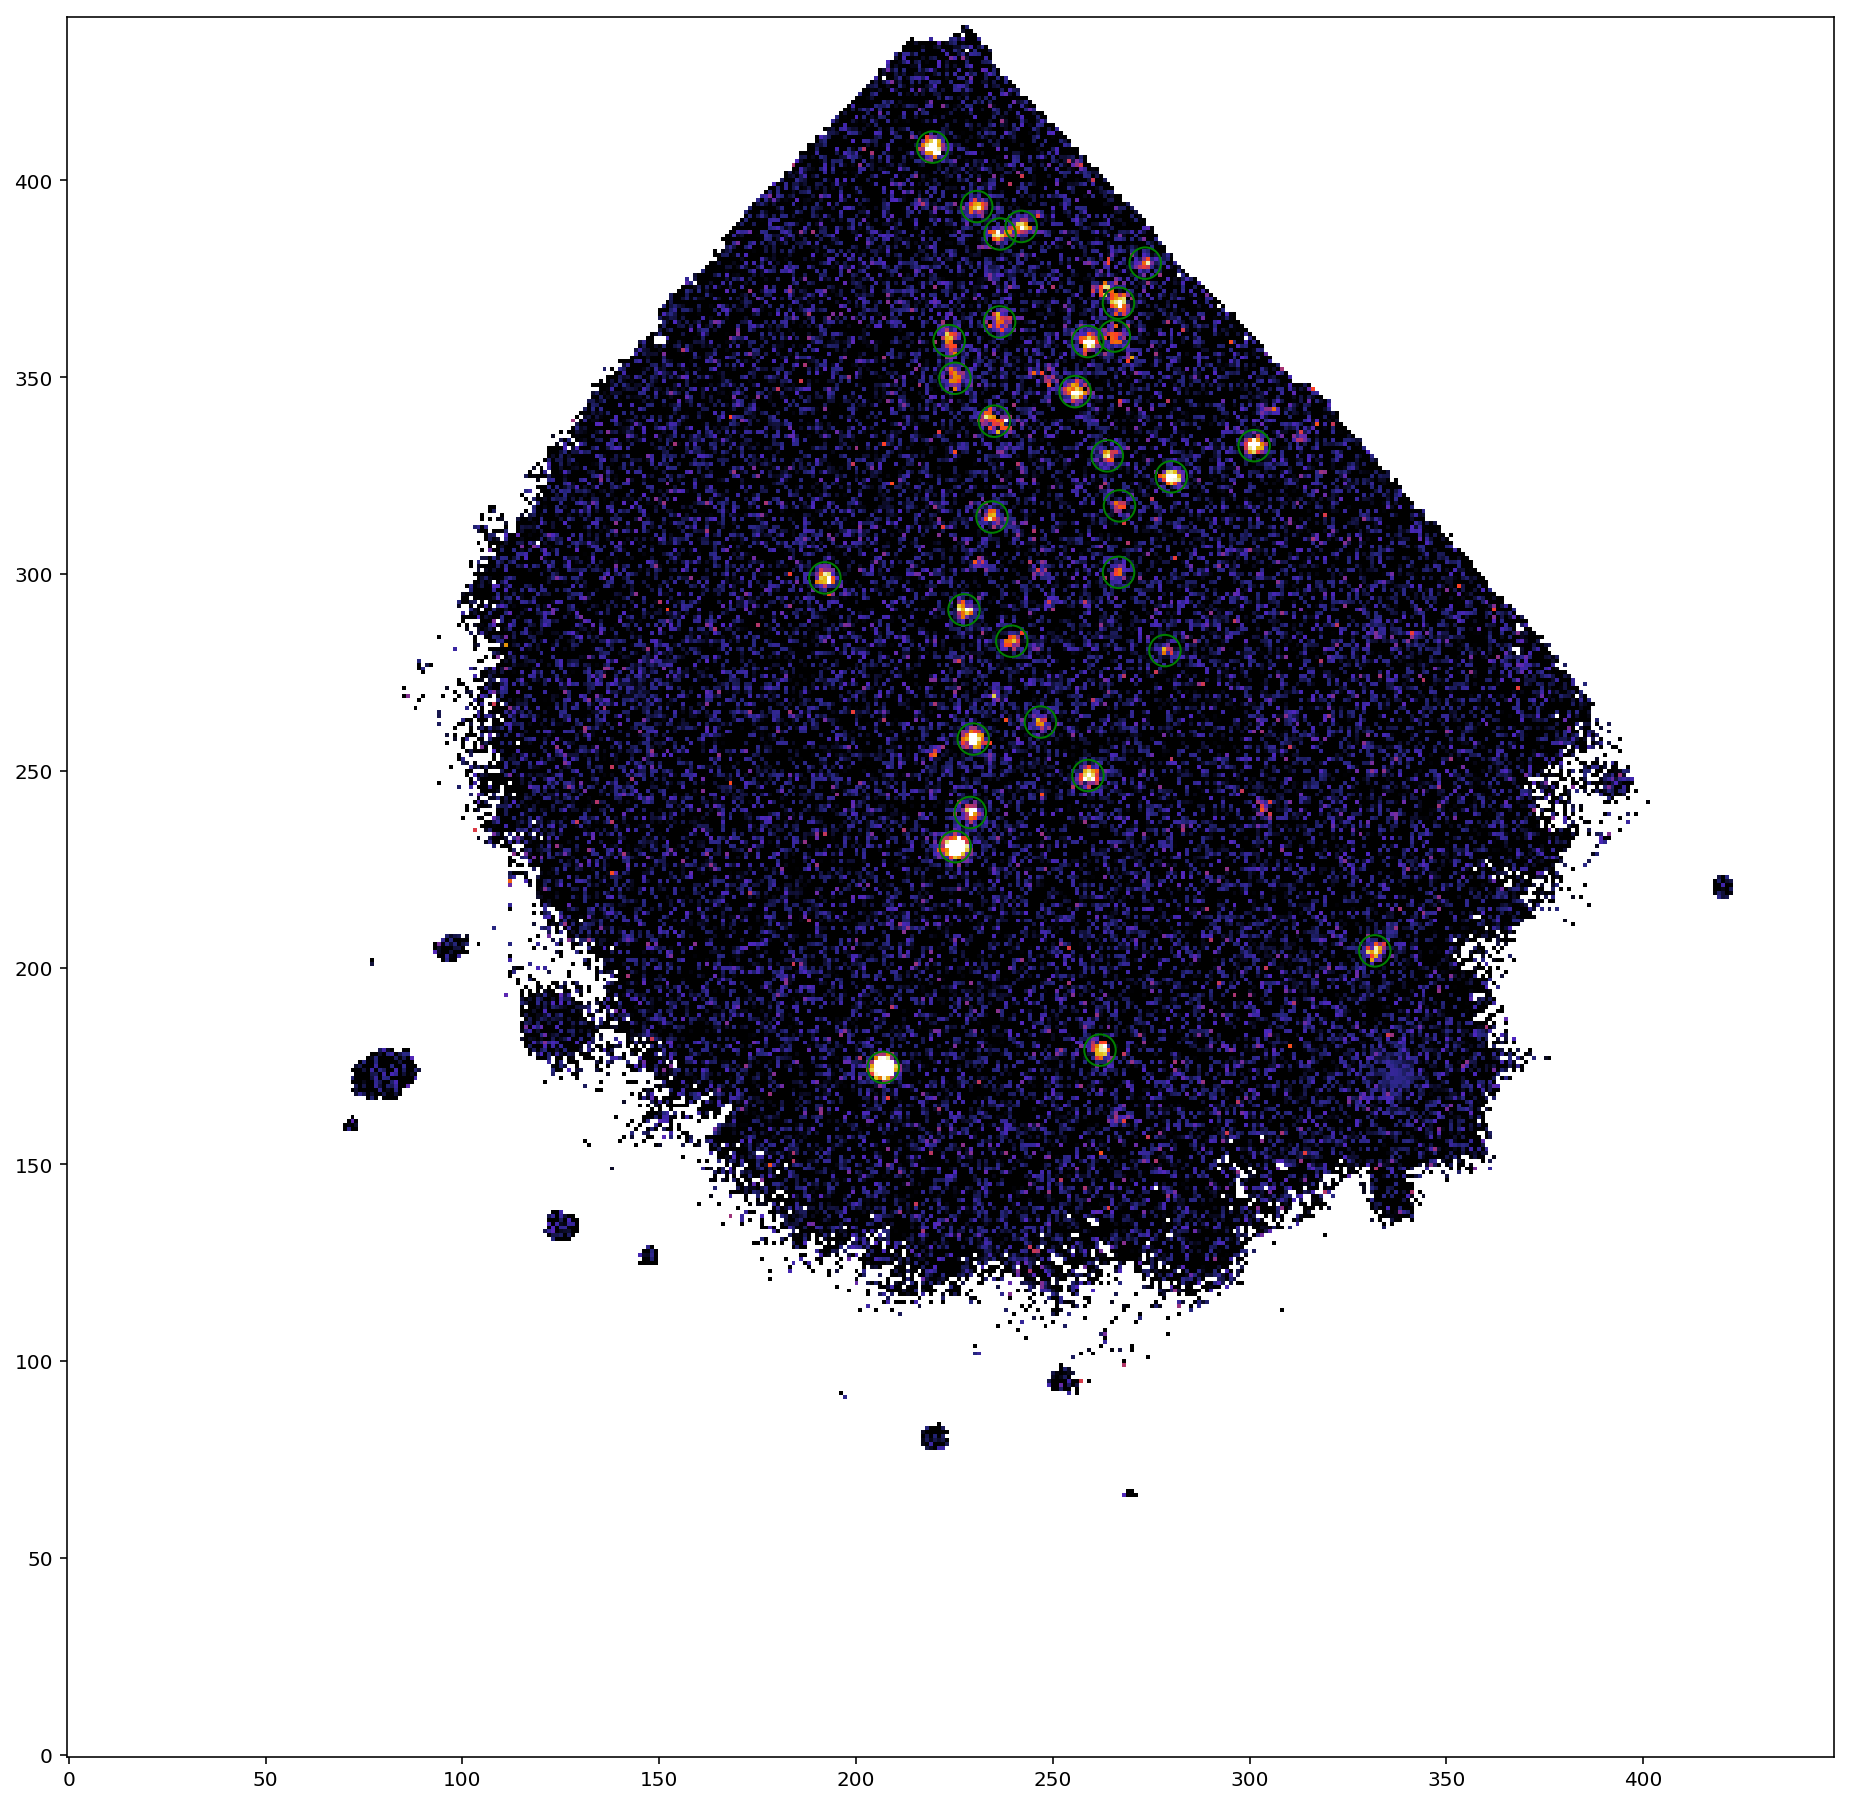

In [22]:
import sep
from photutils import CircularAperture

objects = sep.extract(A_rN_shape, 2.5, clean=True)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=7.)
apertures.plot(color="green")


x_sep[26] = x_sep[26]-1
sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]


print(len(x_sep))
np.save("exported_data/FCC255/sep_x_y_list", sep_x_y_list)